# 004: Grain Mapping
### Map grains by identifying cluster of pixels in orientation space

Method inspired from Johnstone et al. (2020) (https://arxiv.org/abs/2001.02716), using density-based clustering (DBSCAN). The distance metrics combines symmetry-reduced orientations and ($x$,$y$) position of pixels in the sample, to take into account both position and orientation of pixels. 

This notebook has been written to process a stack of 2D slices and map grains in 3D, but it work as well to process just one slice.
***
WARNING: This is a very rough approach, which works as long as the orientation clusters formed by the different grains are well separated. There is no guarantee that groups of pixels identified this way correspond to topologically valid grains: a single cluster can correspond to disconnected groups of pixels / voxels. For more robust grain mapping, there are several methods implemented in MTex which rely on identification of grain boundaries. 
***

### load packages

In [4]:
# general modules
import os, sys
import numpy as np
import pylab as pl
from tqdm import tqdm

# ImageD11 + point-fit 3dxrd module
import ImageD11.grain
import ImageD11.columnfile
import ImageD11.sinograms.dataset

if '/home/esrf/jean1994b/' not in sys.path:
    sys.path.append('/home/esrf/jean1994b/')
from pf_3dxrd import utils, pixelmap, friedel_pairs, crystal_structure, peak_mapping

# orix
from orix import quaternion as oq, vector as ovec

# clustering
from sklearn.cluster import DBSCAN
import sklearn.metrics
from scipy.spatial import KDTree


%matplotlib ipympl
%load_ext autoreload
%autoreload 2

### Load data  

In [5]:
def load_xmap(dsname):
    xmap_file = os.path.join(data_dir, dsname+'_xmap.h5')
    xmap = pixelmap.load_from_hdf5(xmap_file)
    #print(xmap)
    
    return xmap

def load_cf(dset, phase):
    peakfile = os.path.join(data_dir, f'{dsname}_pks_p_flt.h5')
    dsfile = os.path.join(data_dir, f'{dsname}_dataset.h5')
    
    ds = ImageD11.sinograms.dataset.load(dsfile)
    
    cf = ImageD11.columnfile.columnfile(peakfile)
    cf.parameters.loadparameters(parfile)
    cf.updateGeometry()
    friedel_pairs.update_geometry_s3dxrd(cf, ds, update_gvecs=True)
    cf.sortby('xyi')
        
    return cf 

In [14]:
# paths
data_dir = 'data'
parfile='data/SI3.par'
sample = 'SI3'

dslist = ['SI3_DT360Z5480']   # list of datasets to load
phase_name_list = ['quartz', 'orthoclase']  # list of phases to map


Create a dictionnary containing all 2D maps, and build features space for clustering.

In [15]:
%%time
# dictionnary keys
###################
# dset: dataset name
# xmap: pixelmap
# features_[phasename]: normalized 4D space to perform clustering
# mask_[phasename]: mask to select pixels corresponding to the given phase on the map. 

keys = ['dset', 'xmap'] + [f'features_{p}' for p in phase_name_list] +\
                          [f'mask_{p}' for p in phase_name_list]     +\
                          [f'ori_{p}' for p in phase_name_list]

data = [[] for _ in range(len(keys))]
DATA_dict = dict(zip(keys,data))        
    
# load xmaps

for dsname in dslist:
    xmap = load_xmap(dsname)
    xmap.add_data(np.full(xmap.xyi.shape, -1, dtype=np.int16), 'grain_id')
    DATA_dict['dset'].append(dsname)
    DATA_dict['xmap'].append(xmap)

del data  
DATA_dict

CPU times: user 493 ms, sys: 946 ms, total: 1.44 s
Wall time: 406 ms


{'dset': ['SI3_DT360Z5480'],
 'xmap': [<pf_3dxrd.pixelmap.Pixelmap at 0x7ff8a2d57cd0>],
 'features_quartz': [],
 'features_orthoclase': [],
 'mask_quartz': [],
 'mask_orthoclase': [],
 'ori_quartz': [],
 'ori_orthoclase': []}

Build normalized space of features and return the coordinates of each pixels in this space.

In [16]:
def get_normalized_feature_space(xmap, pname):
    """ select orientation from xmap and return normalized feature space built using symetry-reduced orientations 
    (in euler angles) and (x,y) position: (eul1, eul2, xi, yi). Each dimension is rescaled to values between 0 and 1
    
    return:
    features: 4D array of values to perform clustering
    cs: corresponding crystal phase
    mask : phase mask for pixels in xmap
    """
    # phase structure, mask and symmetry
    cs = xmap.phases.get(pname)
    msk = xmap.phase_id == cs.phase_id
    sym = cs.orix_phase.point_group.laue
    # orientation in symmetry reduced zone
    ori_quat = oq.Orientation.from_matrix(xmap.U[msk], symmetry = sym)
    ori_quat = ori_quat.map_into_symmetry_reduced_zone()
    ori_euler = ori_quat.to_euler(degrees=True)
    xi, yi = xmap.xi[msk], xmap.yi[msk]
    
    # normalize
    d1 = ori_euler[:,0] / 360
    d2 = ori_euler[:,1] / 90
    d3 = (xi - xi.min()) / (xi.max() - xi.min())
    d4 = (yi - yi.min()) / (yi.max() - yi.min())
    
    return ori_quat, np.array([d1,d2,d3,d4]).T, cs, msk

def update_dict(pname):
    # compute feature space for each map and update dictionnary
    for xmap in DATA_dict['xmap']:
        ori, features, cs, msk = get_normalized_feature_space(xmap, pname)
        DATA_dict[f'mask_{pname}'].append(msk)
        DATA_dict[f'features_{pname}'].append(features)
        DATA_dict[f'ori_{pname}'].append(ori)


for pname in phase_name_list:
    update_dict(pname)

# print updated dictionnary to check it is ok
# xmap size and mask_phase should have the same shape
# feature_phase shape should be (N,4) with N <= xmap size

for i, dset in enumerate(DATA_dict['dset']):
    print(f'Dataset {dset}\n-----------------------')
    for k,v in DATA_dict.items():
        if 'xmap' in k:
            print(f'{k} size: {v[i].xyi.shape}')
        if any(['features' in k, 'mask' in k]):
            print(f'{k}:{v[i].shape}')
            
    print('=========================')
        
        

Dataset SI3_DT360Z5480
-----------------------
xmap size: (12100,)
features_quartz:(1537, 4)
features_orthoclase:(918, 4)
mask_quartz:(12100,)
mask_orthoclase:(12100,)


Concatenate all arrays of feature into one big array for each phase. This will allow to do clustering in 3D instead of doing it slice by slice (ie. directly identify grains in 3D)

In [17]:
stacked_features = {pname:_ for pname in phase_name_list}

for pname in phase_name_list:
    stacked_features[pname] = np.concatenate([ft for ft in DATA_dict[f'features_{pname}']])
    print(f'All datasets - {pname}: {stacked_features[pname].shape}')

All datasets - quartz: (1537, 4)
All datasets - orthoclase: (918, 4)


### DBSCAN Clustering

In [18]:
# function for clustering

def fit_dbscan(data, eps=0.5, min_samples=5, use_subset=False, downsampling_factor = 2):
    # define model
    model = DBSCAN(eps = eps, min_samples = min_samples)
    
    # select data to cluster: either full data or a subset
    if use_subset:
        data_to_fit = data[::downsampling_factor]
    else: 
        data_to_fit = data
    
    # cluster data
    labels = model.fit_predict(data_to_fit)
    clst, clst_size = np.unique(labels, return_counts=True)
    
    # cluster centroids (for labels != -1, which corresponds to data not assigne dot any cluster
    clst_cs = []
    for i in clst:
        if i == -1:
            continue
        cen = np.median(data_to_fit[labels == i], axis=0)
        clst_cs.append(cen)
    clst_cs = np.array(clst_cs)
    
    # Map full data to nearest subset points (if subset is used)
    if use_subset:
        kd_tree = KDTree(data_to_fit)
        _, nearest_indices = kd_tree.query(data, k=1)
        labels_all = labels[nearest_indices.flatten()]
    else:
        labels_all = labels
    
    return labels_all, clst, clst_size, clst_cs



def performance_metrics(data, labels):
    """ Evaluate the clustering performance using various criteria"""
    ncl = len(np.unique(labels)) - 1
    
    # completeness : prportion of points assigned to a cluster
    completeness = np.count_nonzero(labels != -1)/len(labels) 
    
    #  Mean Silhouette Coeff. Calculated using the mean intra-cluster distance and the mean nearest-cluster distance
    # ranges from 1 (best) to -1 (worst). ~0 : overlapping clusters. <0 : probably wrong cluster assignment
    silhouette = sklearn.metrics.silhouette_score(data, labels, sample_size=10000)
    
    # Davies-Bouldin score: average similarity measure of each cluster with its most similar cluster
    #clusters which are farther apart and less dispersed will result in a better score. The minimum score is zero,
    # with lower values indicating better clustering.
    dbi = sklearn.metrics.davies_bouldin_score(data, labels)
    
    # Variance Ratio Criterion (Calinski and Harabasz score): ratio of the sum of between-cluster dispersion and of
    # within-cluster dispersion. Higher value indicate better clustering, because it means that the data points are
    # more spread out between clusters than they are within clusters. 
    vrc = sklearn.metrics.calinski_harabasz_score(data, labels)
    
    titles = 'N clusters,Completeness,Mean Silhouette Coeff,Davies-Bouldin Score,Variance Ratio Criterion'.split(',')
    stats = [ncl, completeness, silhouette, dbi, vrc]
    performance_stats = {t:arr for t,arr in zip(titles,stats)}
    
    return performance_stats


#### Adjust DBSCAN parameters 

make eps and min_sanple parameters vary over a specified range and evaluate performance of DBSCAN clustering using different metrics, to find the optimal set of values for these parameters

In [41]:
# try different values of eps and min_sample in DBSCAN and evaluate performance.

phase = 'orthoclase'

# define array of eps. Use a wide range first, to see how the performance metrics behave 
eps = np.linspace(0.01,0.15,30)
min_samples = 5

titles = 'N clusters,Completeness,Mean Silhouette Coeff,Davies-Bouldin Score,Variance Ratio Criterion'.split(',')
stats_all = {t:[] for t in titles}


for e in tqdm(eps):
    # find clusters for data subset
    data = stacked_features[phase]
    labels, clst, clst_size, clst_cs = fit_dbscan(data, e, min_samples, use_subset=False)

    # compute performance stats
    try:
        stats = performance_metrics(data, labels)
        for s_all,s_i in zip(stats_all.values(), stats.values()):
            s_all.append(s_i)
        
    except:
        for s_all in stats_all.values():
            s_all.append(np.nan)

vcr = 'Variance Ratio Criterion'
stats_all[vcr] = np.array(stats_all[vcr]) / np.nanmax(stats_all[vcr])

100%|██████████| 30/30 [00:00<00:00, 44.99it/s]


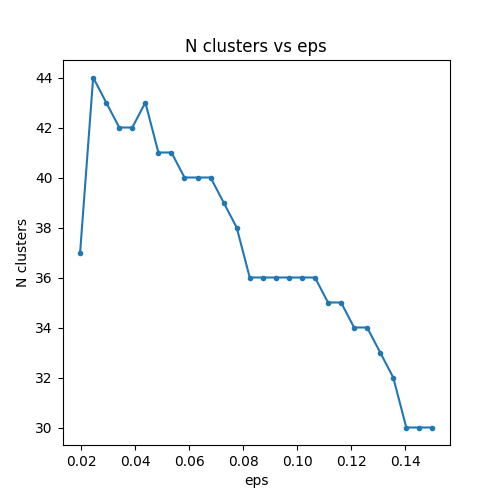

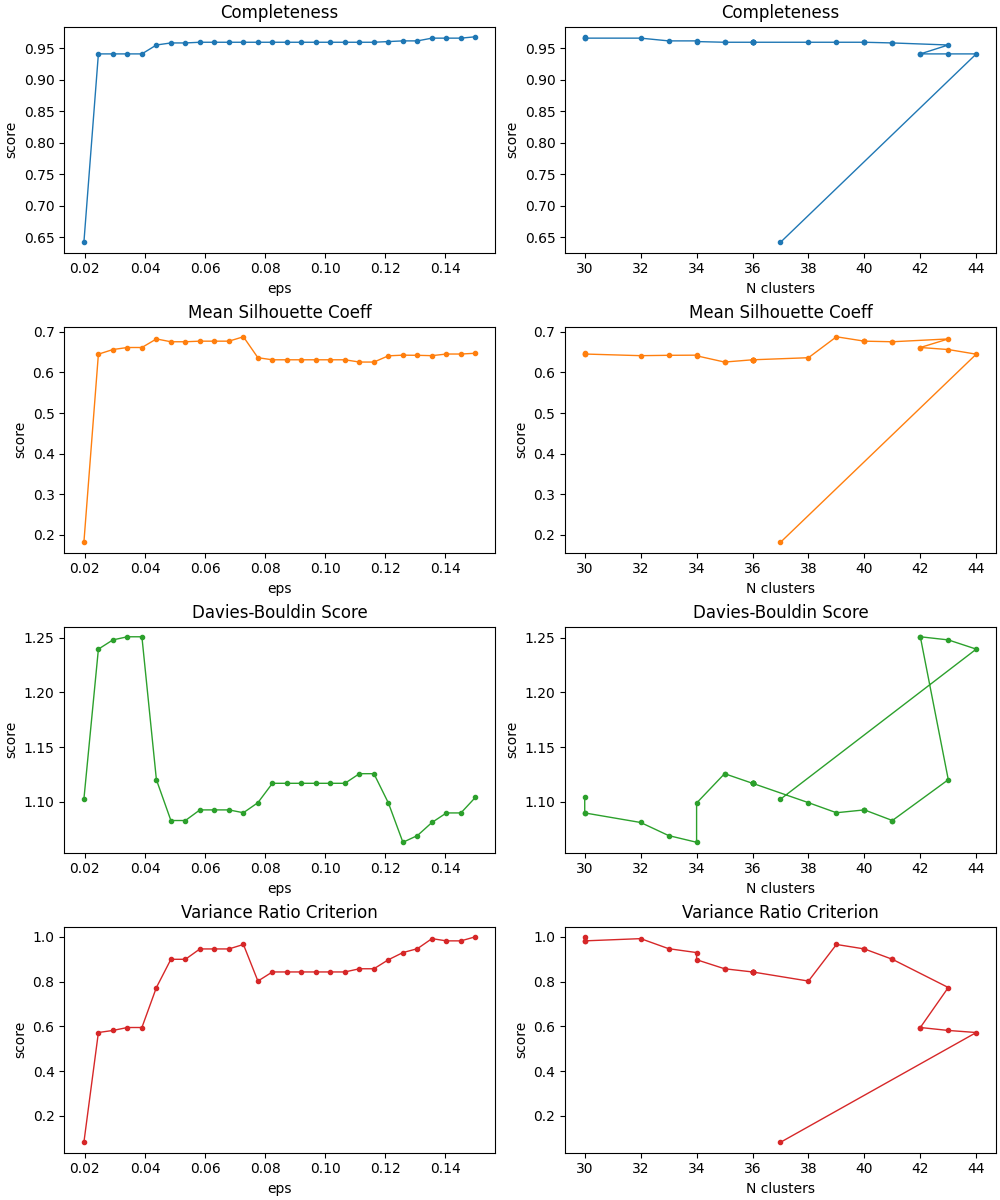

In [42]:
# plot performance index
nrow = len(stats_all) - 1
colors = pl.matplotlib.cm.tab10.colors


pl.figure(figsize=(5,5))
pl.plot(eps, stats_all['N clusters'], '.-')
pl.xlabel('eps')
pl.ylabel('N clusters')
pl.title('N clusters vs eps')

fig, ax = pl.subplots(nrow,2, figsize=(10,3*nrow), layout='constrained')

for i, (t,v) in enumerate(stats_all.items()):
    i = i-1
    if t == 'N clusters':
        continue
    color= colors[i]
    ax[i,0].plot(eps, v, '.-', lw=1., color = color)
    ax[i,0].set_xlabel('eps')
    ax[i,0].set_ylabel('score')
    ax[i,0].set_title(t)
    
    ax[i,1].plot(stats_all['N clusters'], v, '.-', lw=1., color=color)
    ax[i,1].set_xlabel('N clusters')
    ax[i,1].set_ylabel('score')
    ax[i,1].set_title(t)
    
    

### Find grains
Once optimal clustering parameters have been adjusted for all phases, perform DBSCAN clustering. Outputs are stored in two dictionnaries: grain_labels dict contains cluster labels (grain index) for each pixel, and clusters dict contains label, centroid and size of each cluster.

In [69]:
# clustering params for each phase in stacked_features
eps_list = [0.13, 0.08]
min_samples_list = [5, 3]

# initialize dict of results
grain_labels = {p:[] for p in stacked_features}
clusters     = {p:[] for p in stacked_features}

# Clustering: return a grain label for each data point, first in data subset and then in full data
for p,eps,ms in zip(stacked_features, eps_list, min_samples_list):
    
    # find clusters in data subset with dbscan
    labels, clst_ids, clst_size, clst_cs = fit_dbscan(stacked_features[p], eps, ms, use_subset=False)
    
    grain_labels[p] = labels
    clusters[p] = [clst_ids, clst_size, clst_cs]
    print(f'{p} pixels clustering completed. Found {len(clst_ids)-1} unique grains.')
    
    
# We do not want grains from different phases to have the same grain label. Thus we need to update the results so that each phase has its 
# unique set of grain labels
print('===================================')
print('unique grain labels\n----------------------------')
for i, (p, labs) in enumerate(grain_labels.items()):
    
    clst_labs = clusters[p][0]
    
    # for the first phase in grain labels dict, do not change anything
    if i == 0:
        labels_unique = np.unique(labs)
    # for other phases, update labels whenever they are > -1 (-1 stands for non-labeled outliers)
    else:
        labs = np.where(labs == -1, -1, labs + max(labels_unique) + 1)
        clst_labs = np.where(clst_labs == -1, -1, clst_labs + max(labels_unique) + 1)
        labels_unique = np.concatenate((labels_unique,np.unique(labs)))
        grain_labels[p] = labs
        clusters[p][0] = clst_labs
        
        
    # print outputs
    print(f'{p}:\n{np.unique(labs)}\n-----------------------')
    

quartz pixels clustering completed. Found 37 unique grains.
orthoclase pixels clustering completed. Found 43 unique grains.
unique grain labels
----------------------------
quartz:
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36]
-----------------------
orthoclase:
[-1 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79]
-----------------------


### Plots
Make some plots to check grain identification is ok:
- pixels colored by cluster id in symmetry-reduced orientation space
- scatter plot of cluster centroids over ipf color map for each phase. Dot color (within the black circle) is determined from the mean orientation of the cluster, using the same color key as the ipf map. Therefore, the color of each dot should be the same as the color of the corresponding grain. 

In [70]:
# define colormap for clusters
Ncolors = labels_unique.max() + 1
cmap = utils.random_color_map(Ncolors)

In [95]:
# plotting functions

def get_subset_orientations(pname):
    """ return all orientations for the data subset, mapped into the symmetry_reduced zone, for phase pname"""
    # select data
    cs = xmap.phases.get(pname)
    ori_arr = np.concatenate([o.data for o in DATA_dict[f'ori_{pname}']])  # stacked orientations from all maps
    ori_stacked = oq.Orientation(ori_arr, symmetry=cs.orix_phase.point_group.laue)
    ori_stacked.map_into_symmetry_reduced_zone()
    
    return ori_stacked


def get_cluster_orientations(pname):
    """ 
    return mean orientation for all clusters mapped into the symmetry-reduced zone, for phase pname
    """
    cs = xmap.phases.get(pname)
    ori = get_subset_orientations(pname)  # pixel orientation
    
    clst_ids, clst_size, clst_cs = clusters[pname]  # cluster properties: id, size, centroid
    labels = grain_labels[pname]                    # pixel labels in data subset
                          
    # mean cluster orientation
    q_mean = [ori[labels == l].mean() for l in  clst_ids[1:]]
    ori_clusters = oq.Orientation.stack(q_mean).flatten()
    ori_clusters.symmetry = ori.symmetry
    ori_clusters.map_into_symmetry_reduced_zone()
    
    return ori_clusters



def make_ipf_plots(pname, ipf_direction = [0,0,1], save=False):
    """ 
    plot pixel orientation in inverse pole figure space 
    + make scatter plot of cluster centroids overlapped with ipf color map from xmap
    
    pname : phase name 
    cluster_size_factor: adjust spot size for clusters in scatter plot
    ipf_direction: reference direction ofr the inverse pole figure. z-axis = [0,0,1] (default)
    save (bool): save plot
    """
    # extract data
    cs = xmap.phases.get(pname)
    cs.get_ipfkey()
    labels = grain_labels[pname]
    clst_ids, clst_size, clst_cs = clusters[pname]

    # pixel orientations
    ori = get_subset_orientations(pname)
    
    # cluster orientations
    clst_ori = get_cluster_orientations(pname)
    clst_rgb = cs.ipfkey.orientation2color(clst_ori)  # color for plotting
    
    # orientation color map 
    cmap_ori_colors = colors = np.concatenate( (np.array([[0,0,0]]), clst_rgb ), axis=0)  
    cmap_ori = pl.matplotlib.colors.ListedColormap(cmap_ori_colors)
    
    # IPF reference orientation + arguments for plotting
    oref = ovec.Vector3d(ipf_direction)
    kw_subplot = {'projection':'ipf', 'symmetry':cs.orix_phase.point_group.laue, 'direction':oref}
    kw_density = {'cmap':'Reds', 'log':True, 'resolution':.5, 'sigma':.5}

    # fig1 : symmetry-reduced ipf space
    fig1 = pl.figure(figsize=(10,5))
    ax1 = fig1.add_subplot(121, **kw_subplot)
    ax2 = fig1.add_subplot(122, **kw_subplot)

    ax1.scatter(ori, s=2., c = labels, cmap = cmap, vmin=-1, alpha=.3)  # all data point colored by labels
    ax1.scatter(clst_ori, s=20, c = 'k', marker='*', alpha=.5)
    
    ax2.pole_density_function(ori * oref, **kw_density)                 # ipf density map
    fig1.suptitle(f'{pname} clusters')

    # fig2: xmap ipf color map
    
    # rescale cluster centroids to match with xmap coordinates
    msk = xmap.phase_id == cs.phase_id
    xi, yi = xmap.xi[msk], xmap.yi[msk]
    csx = clst_cs[:,2] * (xi.max() - xi.min()) + xi.min() 
    csy = clst_cs[:,3] * (yi.max() - yi.min()) + yi.min() 
    
    fig2 = xmap.plot_ipf_map(pname, ipfdir=ipf_direction, smooth=False, mf_size=3, out=True)
    for col in fig2.axes[0].collections:
        col.set_alpha(0.5)
    fig2.axes[0].scatter(csx, csy, s=50, c=clst_rgb, edgecolors='k', lw=1)
    return clst_ori, clst_rgb, cs
           

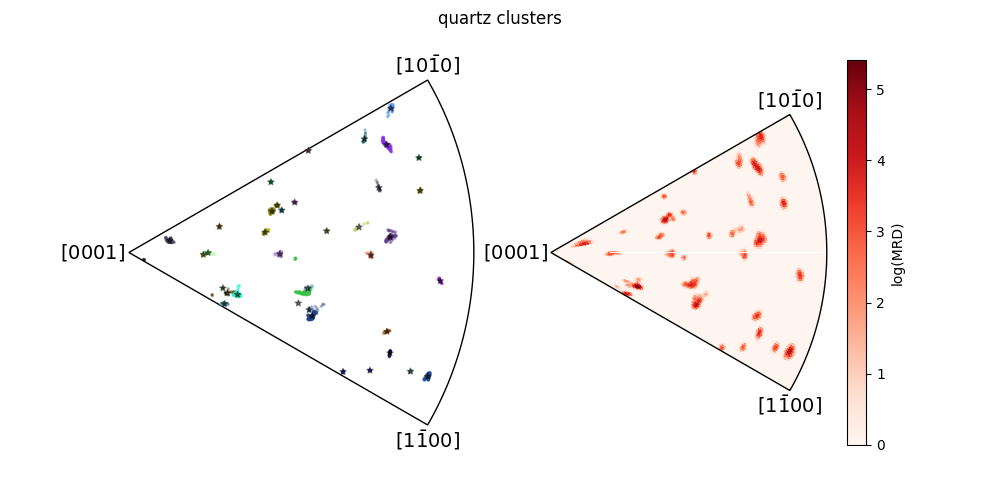

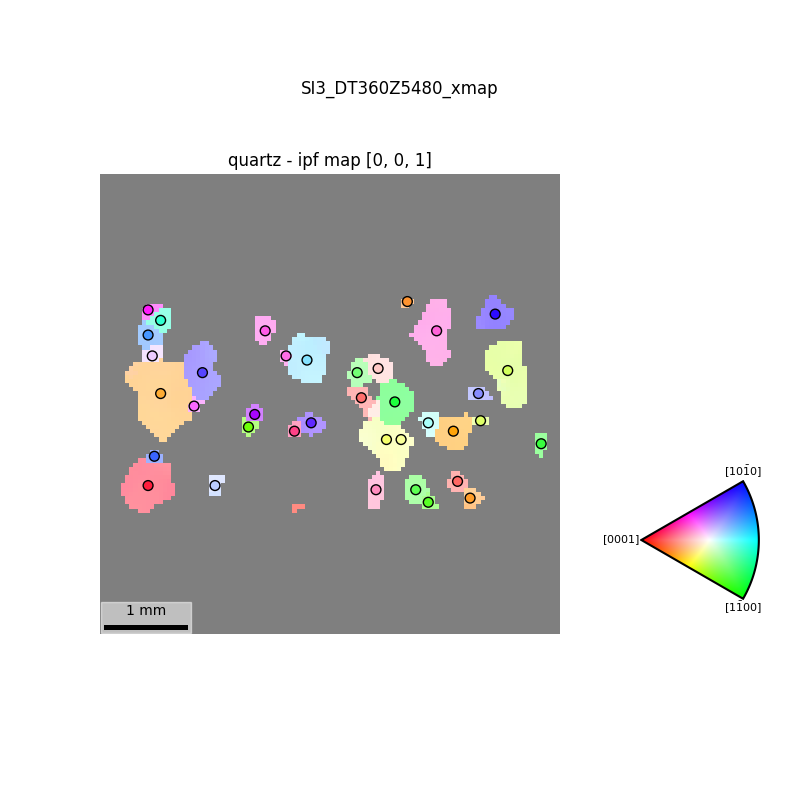

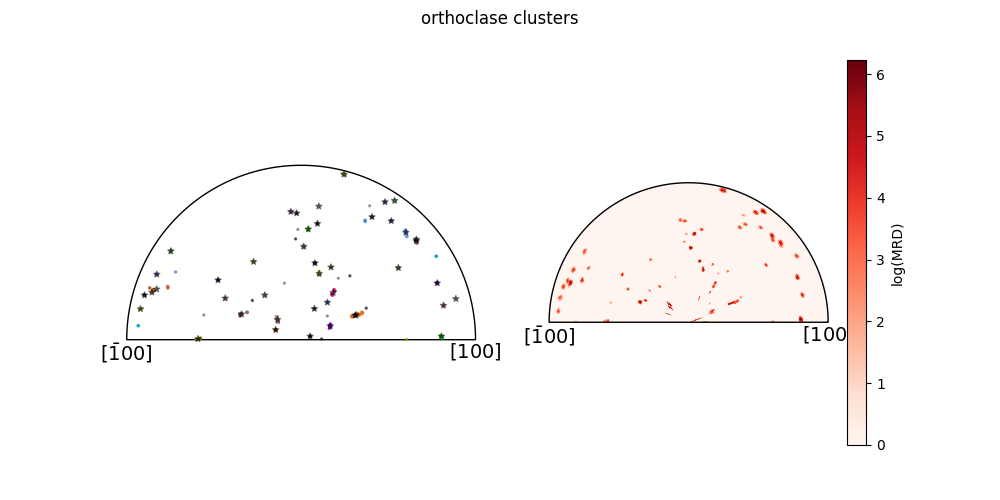

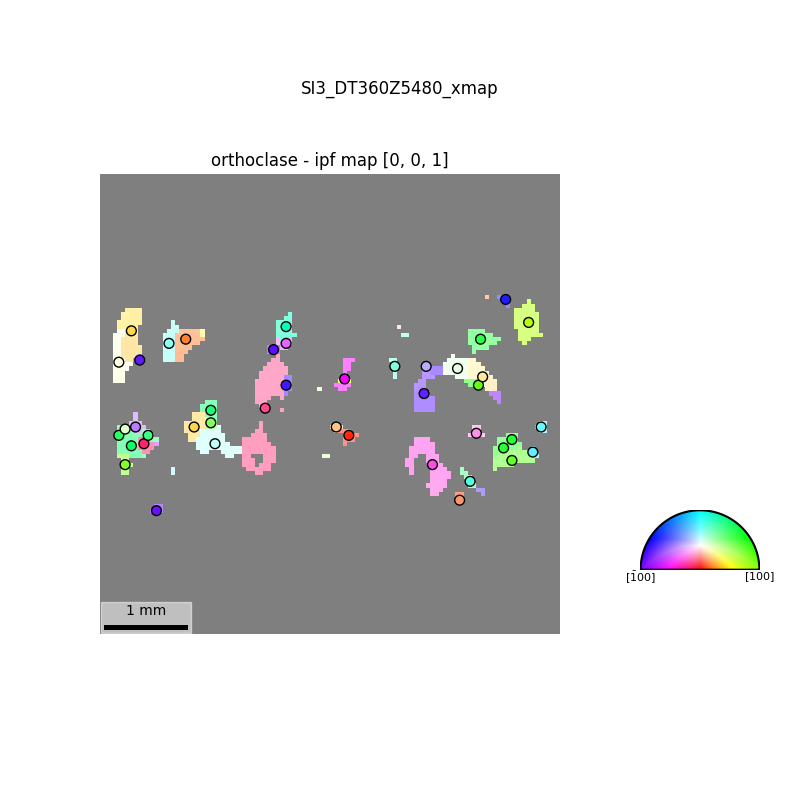

In [96]:
# plots in inverse pole figure space
for pname in phase_name_list:
    clst_ori, clst_rgb, cs = make_ipf_plots(pname, ipf_direction=[0,0,1], save=False)

### Add grain labels to xmaps
extract labels stored in grain_labels dict and update grain_id columns in all 2D pixelmaps in DATA_dict

In [97]:
def add_grain_labels_to_xmaps(pname):
    
    labels_all = grain_labels[pname]    # all labels in 3D stack     
    
    # index positions to split grain_labels[pname] by 2D slices
    inds = [0]
    for f in DATA_dict[f'features_{pname}']:
        inds.append(inds[-1] + len(f) )
    
    # loop through 2D map stack
    print(f'Adding labels to xmaps for phase {pname}')
    for i, (xmap, msk) in tqdm( enumerate(zip(DATA_dict['xmap'], DATA_dict[f'mask_{pname}'])) ):
        # extract labels corresponding to the 2D slice
        labels_slice2D = labels_all[inds[i]:inds[i+1]]
        assert len(labels_slice2D) == np.count_nonzero(msk), 'labels shape does not match with phase mask' # sanity check
        
        # update grain_id labels in xmap
        xmap.update_pixels(xmap.xyi[msk], 'grain_id', labels_slice2D)
        

In [98]:
for pname in phase_name_list:
    add_grain_labels_to_xmaps(pname)

Adding labels to xmaps for phase quartz


1it [00:00, 1342.18it/s]


Adding labels to xmaps for phase orthoclase


1it [00:00, 893.55it/s]


Plot grain masks in each map to check grain label extraction is ok

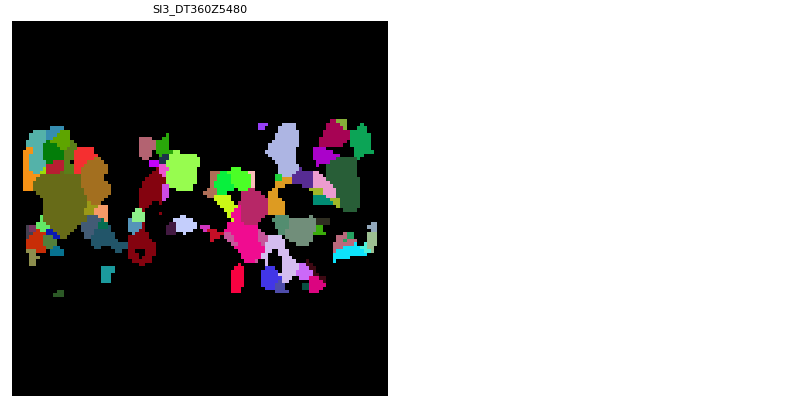

In [99]:
# plot grain_id for each map. Each grain is assigned a random color based on grain_id value
cmap = utils.random_color_map(ncolors=len(labels_unique))

kw = {'cmap':cmap, 'vmin':0, 'vmax':labels_unique.max()}
ncol = 2
nrow = np.ceil(len(DATA_dict['xmap'])/ncol).astype(int)

# grid
xmap = DATA_dict['xmap'][0]
nx, ny = xmap.grid.nx, xmap.grid.ny
xb, yb = xmap.grid.xbins, xmap.grid.ybins


pl.close('all')
fig, ax = pl.subplots(nrow, ncol, figsize=(4*ncol,4*nrow), layout = 'constrained')
ax = ax.ravel()
for a in ax:
    a.set_axis_off()
    a.set_aspect('equal')

for a,x,d in zip(ax, DATA_dict['xmap'], DATA_dict['dset']):
    #m = xmap.phase_id == xmap.phases.orthoclase.phase_id
    m = xmap.phase_id != -1
    gid = np.where(m, xmap.grain_id,-1)
    a.pcolormesh(xb,yb,gid.reshape(nx,ny), **kw)
    a.set_title(d, fontsize=8)
    

#fig.savefig(os.path.join(data_dir, dset, f'{sample}_grain_map.png'), format='png')

Add grains in xmap.grains from grain_id mask: selects subsets of pixels based on grain_id value and computes a "mean" unit cell matrix for each subset, which is then exported as an ImageD11.grain object and added to xmap.grains. 

In [100]:
for x,d in (zip(DATA_dict['xmap'], DATA_dict['dset'])):
    # loop through all phases
    for i, p in enumerate(phase_name_list):
        if i == 0:
            x.add_grains_from_map(p, overwrite=True)
        else:
            x.add_grains_from_map(p, overwrite=False)
            
        print(xmap)

100%|██████████| 38/38 [00:01<00:00, 32.16it/s]


Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'],
 phase_ids: [-1, 0, 1, 2, 3, 4],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id', 'Npks', 'U', 'UBI', 'completeness', 'drlv2', 'nindx', 'phase_label_confidence', 'uniqueness', 'unitcell'], 
 grains: 37


100%|██████████| 44/44 [00:01<00:00, 35.53it/s]

Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'],
 phase_ids: [-1, 0, 1, 2, 3, 4],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id', 'Npks', 'U', 'UBI', 'completeness', 'drlv2', 'nindx', 'phase_label_confidence', 'uniqueness', 'unitcell'], 
 grains: 80


### Add map peaks to grains and refine grain orientations and unit cell matrix
Load peakfiles and do peaks to grain mapping. Then use peaks assigne dto each grain to refine the mean grain unit cell matrix of each grain

In [122]:
# add peakfiles to Data dict
DATA_dict['cf'] = []
    
for dsname in dslist:
    cf = load_cf(dsname,p)
    DATA_dict['cf'].append(cf)

Reading your columnfile in hdf format


In [123]:
# map grains to peakfiles
for xmap, cf in zip(DATA_dict['xmap'], DATA_dict['cf']):
    for i, p in enumerate(phase_name_list): 
        if i == 0:
            xmap.map_pks_to_grains(p, cf, overwrite=True)
        else:
            xmap.map_pks_to_grains(p, cf, overwrite=False)

peaks to grains mapping...


100%|██████████| 37/37 [00:00<00:00, 1431.21it/s]


completed
peaks to grains mapping...


100%|██████████| 43/43 [00:00<00:00, 1617.33it/s]

completed


In [124]:
# check grain labels are consistent in xmap.grain_id, xmap.grains and peakfile

def check_grain_labels(cf, xmap):
    gids_xmap = np.unique(xmap.grain_id)
    gids_glist = np.array(xmap.grains.gids)
    gids_cf = np.unique(cf.grain_id)
    
    assert np.all(np.equal(gids_xmap[1:], gids_glist)), 'grain labels in xmap.grain_id and xmap.grains do not match'
    assert np.all(np.equal(gids_xmap, gids_cf)), 'grain labels in xmap and peakfile do not match'
    
    print('grain labels OK')
    
for xmap,cf in zip(DATA_dict['xmap'], DATA_dict['cf']):
    check_grain_labels(cf, xmap)

grain labels OK


Refine unit cell matrix (UBI) of each grain. See also peak_mapping.refine_grains

In [125]:
def refine_ubis(xmap, cf, pname, hkltol, nmedian, plot_stats=True):
    """
    for each grain, refine ubi using all peaks from cf that have been assigned to this grain
    pname : phase name
    hkltol : hkl tolerance (passed to cImage11.score_and_refine)
    nmedian:  threshold to remove outliers ( abs(median err) > nmedian )
    
    """
    cs = xmap.phases.get(pname)
    pkprop, ang_dev = xmap.refine_ubis( pname, cf, hkltol, nmedian=10, sym = cs.orix_phase.point_group.laue)
    
    if plot_stats:   
        gids = xmap.grains.get_all('gid', pname)
        gs = xmap.grains.get_all('grainsize', pname)
        
        fig = pl.figure(figsize=(5,5))
        fig.add_subplot(111)
        
        pl.scatter(pkprop, ang_dev, c = gids, s = 50 * (gs/max(gs)))
        pl.title(f'refinement stats {pname}')
        pl.xlabel('prop pks retained')
        pl.ylabel('orientation shift (deg)')
    
    return pkprop, ang_dev

refining ubis...


100%|██████████| 37/37 [00:00<00:00, 95.81it/s] 


refining ubis...


100%|██████████| 43/43 [00:00<00:00, 227.44it/s]


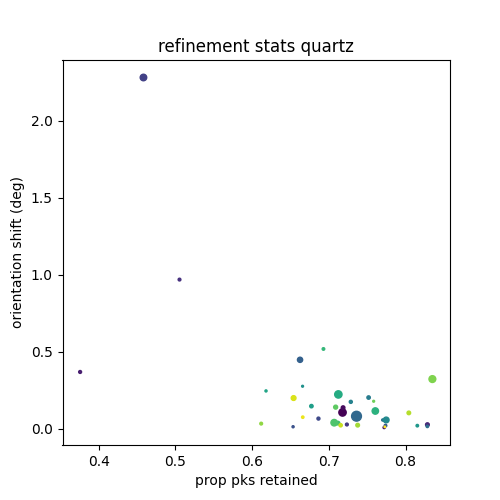

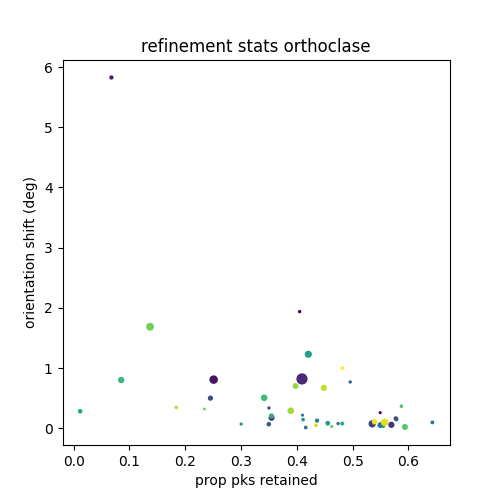

In [126]:
for xmap,cf in zip(DATA_dict['xmap'], DATA_dict['cf']):
    for pname in phase_name_list:
        pkprop, ang_dev = refine_ubis(xmap, cf, pname, hkltol=0.1, nmedian=30, plot_stats=True)

In [127]:
# Once grain ubis have been refined, save files
for xmap,cf in zip(DATA_dict['xmap'], DATA_dict['cf']):
    pkspath = xmap.h5name.replace('xmap', 'pks_p_flt')
    xmap.save_to_hdf5()
    utils.colf_to_hdf(cf, pkspath, save_mode='minimal')

Pixelmap saved to: data/SI3_DT360Z5480_xmap.h5


***
### Map and plot grain properties

Grain mapping has been completed. Below are a few examples of plots that can be done using average grain properties. 

In [128]:
# select one xmap
xmap = DATA_dict['xmap'][0]

# filter to keep only quartz grains
xmap2 = xmap.filter_by_phase('orthoclase')
print(xmap2)

Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'orthoclase'],
 phase_ids: [-1, 3],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id', 'Npks', 'U', 'UBI', 'completeness', 'drlv2', 'nindx', 'phase_label_confidence', 'uniqueness', 'unitcell'], 
 grains: 43


In [133]:
Ncolors = max(xmap2.grains.gids)
cmap = utils.random_color_map(ncolors=Ncolors)

kw = {'cmap':cmap, 'vmin':-2, 'vmax':Ncolors+1}

'data/SI3_DT360Z5480_grainmap_quartz.png'

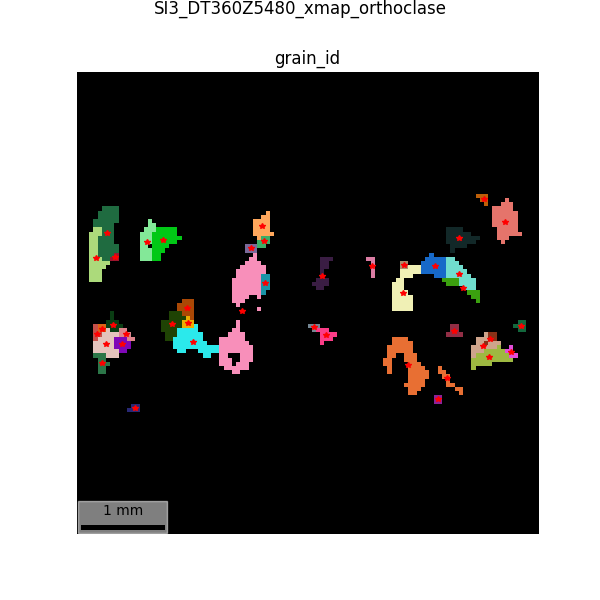

In [134]:
# plot map of grain_id + add position of grain centroids

cen = xmap2.grains.get_all('centroid', 'orthoclase')
xb, yb = xmap2.grid.xbins, xmap2.grid.ybins
nx ,ny = xmap2.grid.nx, xmap2.grid.ny

fig = xmap2.plot('grain_id', autoscale=False, **kw, out=True, hide_cbar=True)
fig.axes[0].plot(cen[:,0], cen[:,1],'r*', ms=4.)

fname =os.path.join(data_dir,f'{dsname}_grainmap_quartz.png')
fname
#fig.savefig(fname, format='png', dpi=150)

/home/esrf/jean1994b/pf_3dxrd/pixelmap.py:217: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = pl.figure(figsize=(6,6))


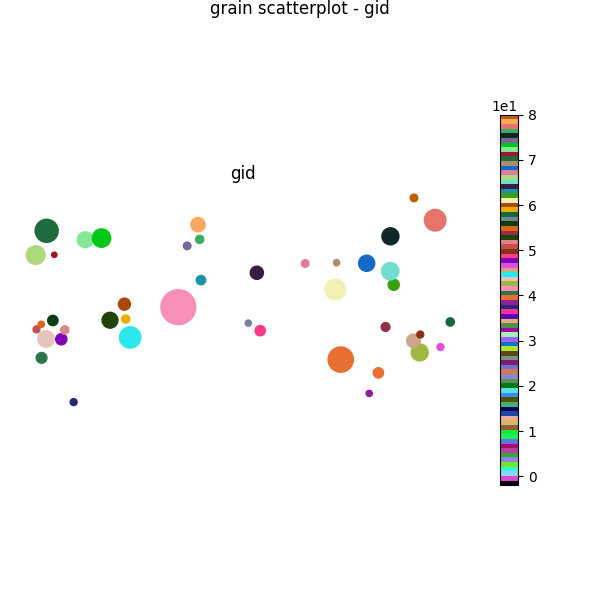

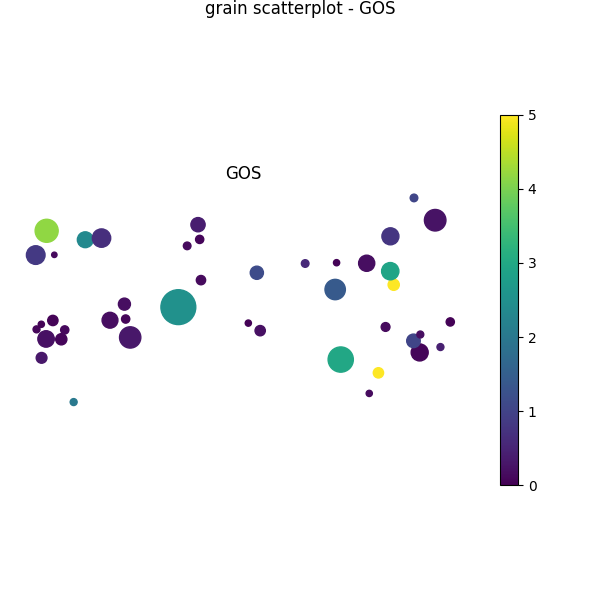

In [137]:
# you can also plot grain prperties in a scatterplot, where circle radius scales with grain size

# grain id
xmap2.grains.plot_grains_prop('gid', s_factor=1/5, **kw)

# grain orientation spread GOS
kw2 = {'vmin':0, 'vmax':5}
xmap2.grains.plot_grains_prop('GOS', s_factor=1/5, autoscale=False, **kw2)

Another useful feature: you can map grain properties to the 2D pixel grid. e.g below for the grain orientation spread. Average grain properties are added as a new column in pixelmap with an '_g' in the end to distinguish them from original pixel properties

43it [00:00, 59938.54it/s]


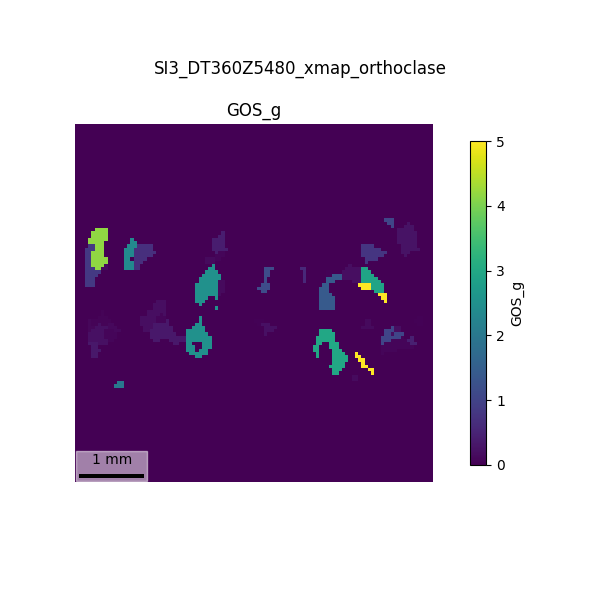

In [138]:
xmap2.map_grain_prop('GOS', pname='orthoclase')
xmap2.plot('GOS_g', autoscale=False, **kw2)

If you do it with orientation matrix U, it will also compute pixel misorientation (ie deviation from average grain orientation in degree for each pixel assigned to a grain mask)

43it [00:00, 1023.13it/s]


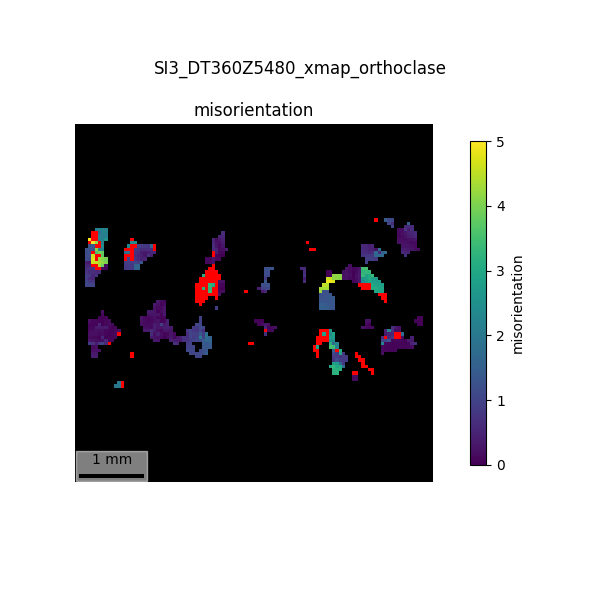

In [154]:
# map grain orientation
xmap2.map_grain_prop('U', pname='orthoclase')

# reset notindexed pixels to -1 
notindexed = xmap2.phase_id != xmap2.phases.orthoclase.phase_id
xmap2.misorientation[notindexed] = -1

# make a plot
cmap_o = pl.matplotlib.cm.viridis.copy()
cmap_o.set_extremes(under='k', over='r')

kw = {'cmap':cmap_o, 'vmin':0,'vmax':5}
xmap2.plot('misorientation', autoscale=False, save=False, **kw)